In [10]:
%matplotlib inline
%run analyze_traj.py
data_dir='/home/amichaut/Desktop/charlene/data/100frames'
df=get_data(data_dir,refresh=False)
df2=filter_by_traj_len(df,min_traj_len=98)
parallelize=False

In [8]:
df2=filter_by_traj_len(df,min_traj_len=50)
df2.shape

NameError: name 'filter_by_traj_len' is not defined

In [92]:
#### PLOT VFIELD
if parallelize:
    num_cores = multiprocessing.cpu_count()
    Parallel(n_jobs=num_cores)(delayed(run)(cur_dir,refresh=refresh,interactive=interactive,plot_frame=plot_frame,plot_data=plot_data,plot_modified_tracks=plot_modified_tracks,plot_all_traj=plot_all_traj,plot_persistence=plot_persistence) for cur_dir in dir_list)

groups=df2.groupby('frame')
for frame in df['frame'].unique():
    avg_vfield=plot_frame_vfield(df,groups,frame,data_dir,avg_grid=10,plot_field=False)
    div=plot_frame_div(df,groups,frame,data_dir,avg_vfield)

plotting frame 0.0

IOError: [Errno 2] No such file or directory: '/home/amichaut/Desktop/charlene/data/100frames/raw/max_intensity_0000.png'

In [ ]:
#### PLOT TRAJ
df_=df2
z_lim=[df_['z_rel'].min(),df_['z_rel'].max()]
groups=df_.groupby('frame')
for frame in df_['frame'].unique():
    plot_frame_cells(df_,groups,frame,data_dir,z_lim=z_lim,plot_traj=True,hide_labels=True,no_bkg=True)


plotting frame 33.0

In [72]:
#### GENERATE SYNTHETIC DATA

part_num=10
frame_num=25
x0=10;y0=10;z0=10
xmax=100;ymax=100;zmax=100;
shift=50
traj=array([]);frame=array([]);x=array([]);y=array([]);z=array([])
for i in range(part_num):
    traj=np.concatenate((traj,ones(frame_num)*i))
    frame=np.concatenate((frame,arange(frame_num)))
    x=np.concatenate((x,linspace(x0,xmax,frame_num)))
    y=np.concatenate((y,linspace(y0+i*shift,ymax+i*shift,frame_num)))
    z=np.concatenate((z,linspace(z0,zmax,frame_num)))

a=np.vstack([arange(frame_num*part_num),traj,frame,x,y,z,zeros((6,frame_num*part_num))]).T
    
df=pd.DataFrame(a,columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
savetxt('test_data.txt',a,delimiter='\t')

[-1, 7, -1, 7]

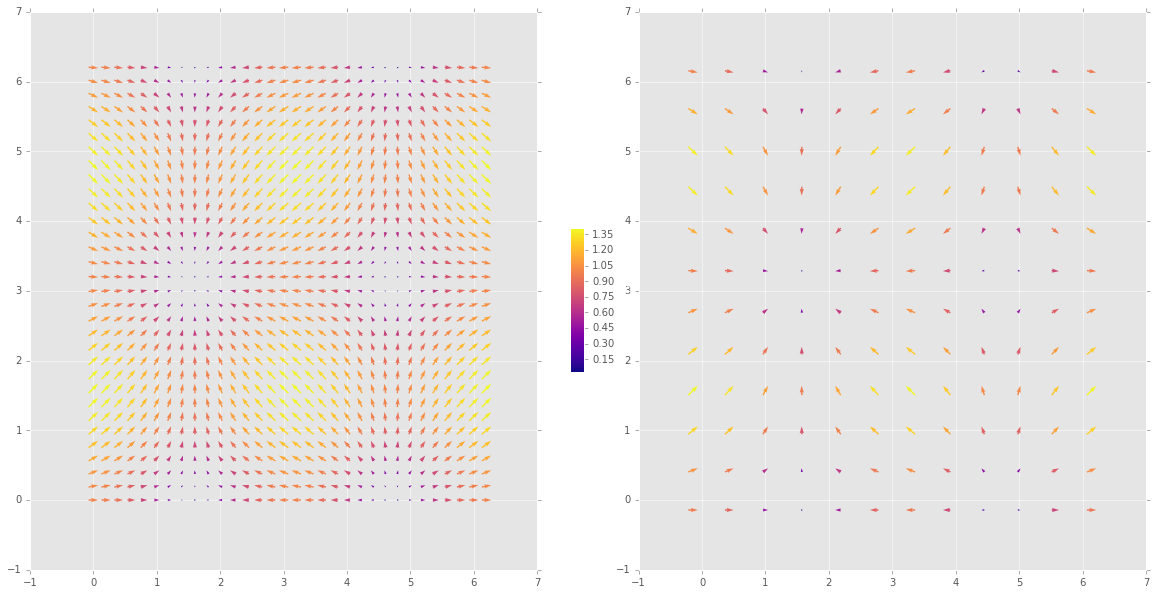

In [91]:
### TEST QUIVER

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
M = np.hypot(U, V)
Q = ax.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

xmin, ymin, xmax, ymax=ax.axis()

cbaxes = fig.add_axes([0.5, 0.4, 0.01, 0.2]) 
cbar = fig.colorbar(Q,cax = cbaxes,label='$v_z\ (\mu m.min^{-1})$')
cbaxes.yaxis.label.set_color('white')
ax.axis([-1, 7, -1, 7])

### average grid

a=hstack([X.reshape(32*32,1),Y.reshape(32*32,1),U.reshape(32*32,1),V.reshape(32*32,1),M.reshape(32*32,1)])
df=pd.DataFrame(a,columns=['x','y','vx','vy','vz'])

#make subgrid
res=15
xmin, xmax, ymin, ymax = [-1, 7, -1, 7]
xsubgrid=linspace(xmin,xmax,res);ysubgrid=linspace(ymin,ymax,res)
X=[];Y=[];VX=[];VY=[];VZ=[] #new data
for i,xg in enumerate(xsubgrid[:-1]):
    for j,yg in enumerate(ysubgrid[:-1]):
        xg1=xsubgrid[i+1];yg1=ysubgrid[j+1]
        ind=((df['x']>=xg) & (df['x']<xg1) & (df['y']>=yg) & (df['y']<yg1))
        VX.append(df[ind]['vx'].mean());VY.append(df[ind]['vy'].mean());VZ.append(df[ind]['vz'].mean())
        X.append(xg+(xg1-xg)*0.5);Y.append(yg+(yg1-yg)*0.5) #center of the cell

Q = ax1.quiver(X,Y,VX,VY,VZ,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

ax1.axis([-1, 7, -1, 7])

In [70]:
%run analyze_traj.py
avg_vfields=get_avg_vfields(data_dir)

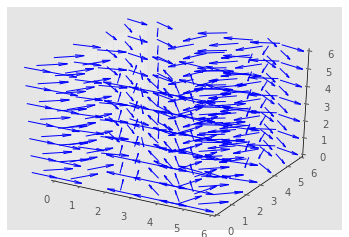

In [17]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')

step=1

x, y, z = np.meshgrid(np.arange(0, 2 * np.pi, step),
                      np.arange(0, 2 * np.pi, step),
                      np.arange(0, 2 * np.pi, step))

u = np.cos(x)
v = np.sin(y)
w = np.ones(x.shape)*(0)

ax.quiver(x, y, z, u, v, w, length=1)

In [137]:
def z_flow(df,z0,grid,plot_field):
    df_layer=df[abs(df['vz'])>=abs(z0-df['z'])] #layer of cells crossing the surface
    df_ascending=df_layer[((df_layer['vz']>=0) & (df_layer['z']<=z0))] #ascending cells below the surface
    df_descending=df_layer[((df_layer['vz']<=0) & (df_layer['z']>=z0))] #descending cells above the surface
    
    #calculate the intersection coordinates (x0,y0) of the vector and the surface (calculate homothety coefficient alpha)
    for df_ in [df_ascending,df_descending]:
        df_['alpha']=(z0-df_['z'])/df_['vz']
        df_['x0']=df_['x']+df_['alpha']*df_['vx']
        df_['y0']=df_['y']+df_['alpha']*df_['vy']
        
    X,Y=grid
    x = zeros((X.shape[0]-1,X.shape[1]-1)); y = zeros((X.shape[0]-1,X.shape[1]-1)); flow = zeros((X.shape[0]-1,X.shape[1]-1))
    for i in range(X.shape[0]-1):
        for j in range(X.shape[1]-1):
            ind_asc=((df_ascending['x0']>=X[i,j]) & (df_ascending['x0']<X[i,j+1]) & (df_ascending['y0']>=Y[i,j]) & (df_ascending['y0']<Y[i+1,j]))
            ind_des=((df_descending['x0']>=X[i,j]) & (df_descending['x0']<X[i,j+1]) & (df_descending['y0']>=Y[i,j]) & (df_descending['y0']<Y[i+1,j]))
            x[i,j]=X[i,j]+(X[i,j+1]-X[i,j])*0.5; y[i,j]=Y[i,j]+(Y[i+1,j]-Y[i,j])*0.5
            flow[i,j]=df_ascending[ind_asc].shape[0]-df_descending[ind_des].shape[0]
    
    if plot_field:
        fig=figure();ax=gca()
        vmin=flow.min();vmax=flow.max()
        cmap=cm.plasma
        C=ax.pcolormesh(x,y,flow,cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
        cbaxes = fig.add_axes([0.4, 0.935, 0.025, 0.05])
        cbar = fig.colorbar(C,cax = cbaxes,label='cell flow $(min^{-1})$')
        cbaxes.tick_params(labelsize=5,color='w')
        cbaxes.yaxis.label.set_color('white')
    
    return (x,y,flow)

(array([[ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.],
        [ 15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.]]),
 array([[  40.,   40.,   40.,   40.,   40.,   40.,   40.,   40.,   40.],
        [ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.],
        [ 160.,  160.,  160.,  160.,  160.,  160.,  160.,  160.,  160.],
        [ 220.,  220.,  220.,  220.,  220.,  220.,  220.,  220.,  220.],
        [ 280.,  280.,  280.,  280.,  280.,  280.,  280.,  280.,  280.],
        [ 340.,  340.,  340.,  340.,  340.,  340.,  340.,

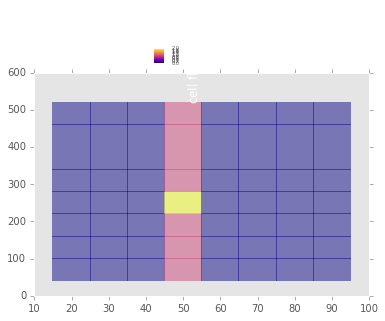

In [144]:
df1=get_data('/home/amichaut/Desktop/charlene/data/test')
grid=meshgrid(linspace(df1['x'].min(),df1['x'].max(),10),linspace(df1['y'].min(),df1['y'].max(),10))
groups=df1.groupby('frame')
group=groups.get_group(10)
z_flow(group,47.6,grid,True)

In [142]:
df1

,traj,frame,x,y,z,m0,m1,m2,m3,m4,NPscore,t,x_scaled,y_scaled,z_scaled,vx,vy,vz,v,z_rel
0,0.0,0.0,10.00,10.00,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.251563,6.251563,6.251563,NaN,NaN,NaN,NaN,-28.132033
1,0.0,1.0,13.75,13.75,13.75,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.595899,8.595899,8.595899,0.293042,0.293042,0.293042,0.507564,-25.787697
2,0.0,2.0,17.50,17.50,17.50,0.0,0.0,0.0,0.0,0.0,0.0,16.0,10.940235,10.940235,10.940235,0.293042,0.293042,0.293042,0.507564,-23.443361
3,0.0,3.0,21.25,21.25,21.25,0.0,0.0,0.0,0.0,0.0,0.0,24.0,13.284571,13.284571,13.284571,0.293042,0.293042,0.293042,0.507564,-21.099025
4,0.0,4.0,25.00,25.00,25.00,0.0,0.0,0.0,0.0,0.0,0.0,32.0,15.628907,15.628907,15.628907,0.293042,0.293042,0.293042,0.507564,-18.754689
5,0.0,5.0,28.75,28.75,28.75,0.0,0.0,0.0,0.0,0.0,0.0,40.0,17.973243,17.973243,17.973243,0.293042,0.293042,0.293042,0.507564,-16.410353
6,0.0,6.0,32.50,32.50,32.50,0.0,0.0,0.0,0.0,0.0,0.0,48.0,20.317579,20.317579,20.317579,0.293042,0.293042,0.293042,0.507564,-14.066017
7,0.0,7.0,36.25,36.25,36.25,0.0,0.0,0.0,0.0,0.0,0.0,56.0,22.661915,22.661915,22.661915,0.293042,0.293042,0.293042,0.507564,-11.721680
8,0.0,8.0,40.00,40.00,40.00,0.0,0.0,0.0,0.0,0.0,0.0,64.0,25.006252,25.006252,25.006252,0.293042,0.293042,0.293042,0.507564,-9.377344
9,0.0,9.0,43.75,43.75,43.75,0.0,0.0,0.0,0.0,0.0,0.0,72.0,27.350588,27.350588,27.350588,0.293042,0.293042,0.293042,0.507564,-7.033008


In [7]:
xmin=0;xmax=10;ymin=10;ymax=100;xres=10
step=float(xmax-xmin)/xres
node_grid=meshgrid(arange(xmin,xmax+step,step),arange(ymin,ymax+step,step))
center_grid=meshgrid(arange(xmin+step/2,xmax,step),arange(ymin+step/2,ymax,step))

In [9]:
node_grid+1

TypeError: can only concatenate list (not "int") to list

In [10]:
df=pd.DataFrame({'a':node_grid,'b':node_grid})

In [11]:
df

,a,b
0,"[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
1,"[[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10...","[[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10..."


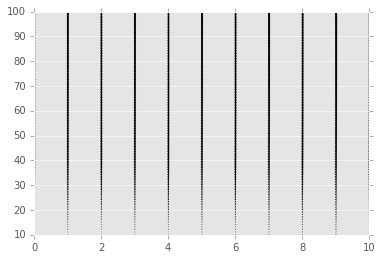

In [23]:
l=[node_grid[0],node_grid[1]]
quiver(node_grid[0],node_grid[1],*l,cmap='plasma')

In [26]:
array(l).shape

(2, 91, 11)

In [27]:
V=zeros()
for k in range(dim):
    V+=node_grid[k]**2
mean_vel=sqrt(V) 

In [28]:
V

array([[   100.,    101.,    104., ...,    164.,    181.,    200.],
       [   121.,    122.,    125., ...,    185.,    202.,    221.],
       [   144.,    145.,    148., ...,    208.,    225.,    244.],
       ..., 
       [  9604.,   9605.,   9608., ...,   9668.,   9685.,   9704.],
       [  9801.,   9802.,   9805., ...,   9865.,   9882.,   9901.],
       [ 10000.,  10001.,  10004., ...,  10064.,  10081.,  10100.]])

In [29]:
mean_vel

array([[  10.        ,   10.04987562,   10.19803903, ...,   12.80624847,
          13.45362405,   14.14213562],
       [  11.        ,   11.04536102,   11.18033989, ...,   13.60147051,
          14.2126704 ,   14.86606875],
       [  12.        ,   12.04159458,   12.16552506, ...,   14.4222051 ,
          15.        ,   15.62049935],
       ..., 
       [  98.        ,   98.00510191,   98.02040604, ...,   98.32598843,
          98.41239759,   98.50888285],
       [  99.        ,   99.00505038,   99.02019996, ...,   99.32270637,
          99.40824915,   99.50376877],
       [ 100.        ,  100.00499988,  100.019998  , ...,  100.31948963,
         100.40418318,  100.49875621]])